<a href="https://colab.research.google.com/github/sush104/Crisis_Event_Ranking_and_Summarization/blob/main/CrisisFACTs_Sushant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TREC CrisisFACTs Track 2022 Tutorial

This notebook illustrates how to download the TREC 2022 CrisisFACTs event streams along with the information needs for each one.

**Part 1: Installing Needed Packages**

Before we can get the data, we need to install some packages to handle the download process, as well as to enable some analysis we will do later in this tutorial. In particular, we are going to install two main packages


*   ir_datasets (https://github.com/allenai/ir_datasets): A python package that provides a common interface to many IR ad-hoc ranking benchmarks, training datasets, etc. We can use this to download the raw event streams and information needs for each.
*   pyTerrier (https://pyterrier.readthedocs.io/en/latest/): pyTerrier is a python wrapper around the Terrier IR Platform (a search engine in-a-box). We will use this to produce a searchable index for each day during a crisis event, so we can retrieve (hopefully) relevant content for different information needs. 



In [ ]:
!pip install -q git+https://github.com/allenai/ir_datasets.git@crisisfacts # install ir_datasets (crisisfacts branch)
!pip install -q python-terrier # install pyTerrier

**Import required libraries** 

In [ ]:
import pandas as pd
import json
import pyterrier as pt
import ir_datasets
from urllib.request import urlopen
import gensim.downloader as api
import json
import numpy as np

**Part 2: Initalizing Your Credentials**

When you want to download part of the CrisisFACTs dataset we require that you provide a set of contact details. The reason for this is two-fold: 1) the terms of service from some of the platforms (like Twitter) from which we have sourced data require us to do so, and 2) it allows us to collect statistics on how many people are making use of the data we provide.

**GDPR Statement**: By downloading the CrisisFACTs datasets, you agree to the University of Glasgow processing your personal data, as defined by the EU General Data Protection Regulation (GDPR) - your name and email in this case. Queries about data processing and access/deletion requests should be sent to [me via email](http://www.dcs.gla.ac.uk/~richardm/Home/Contact.html). We will store your data for as long as the track is on-going and up-to 2 years beyond that. I may contact you using the details provided to notify you about changes in the datasets or track, to provide information or ask you questions about your participation or otherwise contact you about topics relevant to emergency management. We may collate statistics from the provided information that will be published, but we will not release individual names or email addresses. 

Rather than entering these details every time you request the dataset, its more effcient to set this once up-front, so fill in your details below:

In [ ]:
credentials = {
    "institution": "University of Foo", # University, Company or Public Agency Name
    "contactname": "Foo Bar", # Your Name
    "email": "foo@bar.edu", # A contact email address
    "institutiontype": "Research" # Either 'Research', 'Industry', or 'Public Sector'
}

# Write this to a file so it can be read when needed
!mkdir -p /root/.ir_datasets/auth/
with open('/root/.ir_datasets/auth/crisisfacts.json', 'w') as f:
    json.dump(credentials, f)

**Part 3: Understanding the structure of the CrisisFACTs Dataset**

The CrisisFACTs dataset is divided into events, representing real-world crises. Each event is given an identifier, e.g. 'CrisisFACTS-001' is the Lilac Wildfire from 2017. We sometimes refer to the event number or 'eventNo', this is the last three digits of the event identifier, e.g. '001'. There are 8 events for CrisisFACTs 2022:

In [ ]:
# Event numbers as a list
eventNoList = [
          "001", # Lilac Wildfire 2017
          "002", # Cranston Wildfire 2018
          "003", # Holy Wildfire 2018
          "004", # Hurricane Florence 2018
          "005", # 2018 Maryland Flood
          "006", # Saddleridge Wildfire 2019
          "007", # Hurricane Laura 2020
          "008" # Hurricane Sally 2020
]

Each event has a duration, i.e. it lasts for a number of days. In the CrisisFACTs track, you need to produce a timeline summary for each day for a set of events. You can get the list of days for an event as shown below (example is for event "001", i.e. the Lilac Wildfire 2017):

In [ ]:
# Gets the list of days for a specified event number, e.g. '001'
def getDaysForEventNo(eventNo):

  # We will download a file containing the day list for an event
  url = "http://trecis.org/CrisisFACTs/CrisisFACTS-"+eventNo+".requests.json"

  # Download the list and parse as JSON
  dayList = json.loads(urlopen(url).read())

  # Print each day
  # Note each day object contains the following fields
  #   {
  #      "eventID" : "CrisisFACTS-001",
  #      "requestID" : "CrisisFACTS-001-r3",
  #      "dateString" : "2017-12-07",
  #      "startUnixTimestamp" : 1512604800,
  #      "endUnixTimestamp" : 1512691199
  #   }

  return dayList

# for day in getDaysForEventNo(eventNoList[0]):
#   print(day)

For each day, we collected related content to the event from the following sources:


*   **Twitter**: We are re-using tweets collected as part of the TREC Incident Streams track (http://trecis.org). These tweets were crawled by keyword, and as such most are likely to be relevant to the event, but are not nessessaraly good candidates for inclusion into a summary of what is happening.
*   **Reddit**: Discussions regarding what happens during events also occurs on the forum platform Reddit. We collected relevant Reddit threads to each event, where we include both the original submission and subsequent comments within those threads.
*   **News**: Traditional news agencies are often a good source of information during an emergency and so we have also included a small number of news articles collected during each event as well.
*   **Facebook**: We collected Facebook/Meta posts from public pages that are relevant to each event using CrowdTangle. We cannot share the content of these posts, however, we have included the post and page ids of this content within the stream for those who have access to the CrowdTangle API and can retrieve this data separately. 

Because these sources have different formatting and characteristics, we reformatted this data into a list of standardized 'stream items', where a stream item contains:


*   **event**: The identifier of the event, e.g. 'CrisisFACTS-001'
*   **streamID**: A unique identifier for the stream item. This will generally be of the form 'CrisisFACTS-\<eventNo\>-\<source\>-\<postID\>-\<sentenceID\>', e.g. CrisisFACTS-001-Twitter-15712-0.
*   **unixTimestamp**: This is the time that the content was originally posted, expressed as a unix timestamp in seconds (UTC timezone).
*   **text**: The text of the stream item. The maximum length of a stream item is 200 characters. 
*   **sourceType**: A string denoting the source, i.e. either Twitter, Reddit, News or Facebook.
*   **source**: This is the original post content formated as JSON.

Since, some types of content are longer than others (compare a news article vs. a tweet for instance), for long-form content we perform sentence segmentation, so one input post might form multiple stream items. In these cases, the 'sentenceID' component of the streamID denotes the number of the sentence in the source content.


The dataset is structured by day and event. To access the stream items for a particular \<event,day\> pair we generate a request string specifying the day and event we want, of the form:

*   '**crisisfacts/\<eventNo\>/\<day\>**'

For instance, we could generate request strings for all CrisisFACTs \<event,day\> pairs as follows:

In [ ]:

cols = ["Event", "Facts_Date", "Requist_ID"]
stream_df = pd.DataFrame(columns = cols)

for eventNo in eventNoList: # for each event
  dayList = getDaysForEventNo(eventNo) # get the list of days
  for day in dayList: # for each day
    # print("Event "+eventNo)
    # print("  crisisfacts/"+eventNo+"/"+day["dateString"]) # construct the request string
    # stream_df["Event"] = eventNo
    # stream_df["Fast date"] = " crisisfacts/"+eventNo+"/"+day["dateString"]
    stream_df = stream_df.append({'Event': "Event "+eventNo, 'Facts_Date':"crisisfacts/"+eventNo+"/"+day["dateString"], 'Requist_ID':day["requestID"]},ignore_index=True)

In [ ]:
stream_df

,Event,Facts_Date,Requist_ID
0,Event 001,crisisfacts/001/2017-12-07,CrisisFACTS-001-r3
1,Event 001,crisisfacts/001/2017-12-08,CrisisFACTS-001-r4
2,Event 001,crisisfacts/001/2017-12-09,CrisisFACTS-001-r5
3,Event 001,crisisfacts/001/2017-12-10,CrisisFACTS-001-r6
4,Event 001,crisisfacts/001/2017-12-11,CrisisFACTS-001-r7
5,Event 001,crisisfacts/001/2017-12-12,CrisisFACTS-001-r8
6,Event 001,crisisfacts/001/2017-12-13,CrisisFACTS-001-r9
7,Event 001,crisisfacts/001/2017-12-14,CrisisFACTS-001-r10
8,Event 001,crisisfacts/001/2017-12-15,CrisisFACTS-001-r11
9,Event 002,crisisfacts/002/2018-07-25,CrisisFACTS-002-r1


Group by events by to pass each event name to specific dataset at the time of summarization

In [ ]:
event_name_df = stream_df.groupby('Event')
event_name_df.first()

,Facts_Date,Requist_ID
Event,,
Event 001,crisisfacts/001/2017-12-07,CrisisFACTS-001-r3
Event 002,crisisfacts/002/2018-07-25,CrisisFACTS-002-r1
Event 003,crisisfacts/003/2018-08-06,CrisisFACTS-003-r5
Event 004,crisisfacts/004/2018-09-01,CrisisFACTS-004-r8
Event 005,crisisfacts/005/2018-05-27,CrisisFACTS-005-r3
Event 006,crisisfacts/006/2019-10-10,CrisisFACTS-006-r4
Event 007,crisisfacts/007/2020-08-27,CrisisFACTS-007-r13
Event 008,crisisfacts/008/2020-09-11,CrisisFACTS-008-r3


In [ ]:
len(event_name_df["Event"])

8

Now that we know what the request strings for each event and day are, we can download for the associated stream for each via ir_datasets:

In [ ]:

# download the first day for event 001 (this is a lazy call, it won't download until we first request a document from the stream)
# dataset = ir_datasets.load('crisisfacts/002/2018-07-25')

# for item in dataset.docs_iter()[:10]: # create an iterator over the stream containing the first 10 items
#   print(item)

In [ ]:
# pd.DataFrame(dataset.queries_iter())

In [ ]:
# for i in range(0, 1):
#   print("Event: "+stream_df['Event'][i])
#   print("Facts_date: "+stream_df['Facts_Date'][i])
#   dataset = ir_datasets.load(stream_df['Facts_Date'][i])
  # for item in dataset.docs_iter()[:2]: # create an iterator over the stream containing the first 10 items
  #   print(item)

As we can see the first stream items are tweets, and not all of them are relevant, particularly at the begining of the event. If we wanted to find content of other types we can try filtering by the source_type field.

In [ ]:
# # Convert the stream of items to a Pandas Dataframe
# itemsAsDataFrame = pd.DataFrame(dataset.docs_iter())

# # Create a filter expression
# is_reddit =  itemsAsDataFrame['source_type']=="Reddit"
# is_twitter =  itemsAsDataFrame['source_type']=="Twitter"
# is_news =  itemsAsDataFrame['source_type']=="News"
# is_facebook =  itemsAsDataFrame['source_type']=="Facebook"
# # Apply our filter
# # itemsAsDataFrame[is_facebook]

In [ ]:
eventsMeta = {}

for eventNo in eventNoList: # for each event
    dailyInfo = getDaysForEventNo(eventNo) # get the list of days
    eventsMeta[eventNo]= dailyInfo
    
    print("Event "+eventNo)
    for day in dailyInfo: # for each day
        print("  crisisfacts/"+eventNo+"/"+day["dateString"], "-->", day["requestID"]) # construct the request string

    print()

Event 001
  crisisfacts/001/2017-12-07 --> CrisisFACTS-001-r3
  crisisfacts/001/2017-12-08 --> CrisisFACTS-001-r4
  crisisfacts/001/2017-12-09 --> CrisisFACTS-001-r5
  crisisfacts/001/2017-12-10 --> CrisisFACTS-001-r6
  crisisfacts/001/2017-12-11 --> CrisisFACTS-001-r7
  crisisfacts/001/2017-12-12 --> CrisisFACTS-001-r8
  crisisfacts/001/2017-12-13 --> CrisisFACTS-001-r9
  crisisfacts/001/2017-12-14 --> CrisisFACTS-001-r10
  crisisfacts/001/2017-12-15 --> CrisisFACTS-001-r11

Event 002
  crisisfacts/002/2018-07-25 --> CrisisFACTS-002-r1
  crisisfacts/002/2018-07-26 --> CrisisFACTS-002-r2
  crisisfacts/002/2018-07-27 --> CrisisFACTS-002-r3
  crisisfacts/002/2018-07-28 --> CrisisFACTS-002-r4
  crisisfacts/002/2018-07-29 --> CrisisFACTS-002-r5
  crisisfacts/002/2018-07-30 --> CrisisFACTS-002-r6

Event 003
  crisisfacts/003/2018-08-06 --> CrisisFACTS-003-r5
  crisisfacts/003/2018-08-07 --> CrisisFACTS-003-r6
  crisisfacts/003/2018-08-08 --> CrisisFACTS-003-r7
  crisisfacts/003/2018-08-09 -

# Getting the Crisis Reponder Information Needs / Queries

Clearly not all of the information in the input stream for each day will be useful for an emergency responder, or even be relevant. Hence it makes sense that we filter these streams down based on what the emergency responder cares about. Our task is focused on producing timeline summaries containing similar information to what might be entered into an after action report, similar to an ICS 209 form: 
* https://training.fema.gov/emiweb/is/icsresource/assets/ics%20forms/ics%20form%20209,%20incident%20status%20summary%20(v3).pdf

But how can we express this information need in a way that a computer can understand? To make it easier for participant systems to integrate content relevant to the event, we have manually constructed a set of queries that encapsulate this information need. These queries are in effect questions that an emergency responder might ask when writing their after action report.

These queries are included as part of each day of the CrisisFACTs dataset, and can access them as follows:

In [ ]:
# pd.DataFrame(dataset.queries_iter())

##Initialize pyTerrier library


In [ ]:
# Initalize pyTerrier if not started
if not pt.started():
  pt.init()

# Searching for Relevant Content

At this point you know how to get the data streams that you are to summarize, and you know how what ideally should be included within your summary. This is the minimum that you need to tackle the CrisisFACTs task. However, one of the reasons that we integrated the CrisisFACTs datasets into ir_datasets is that it provides you with a plug-and-play means to perform text search of the content for a day via pyTerrier. This is useful as an initial step to find content that is relevant to the emergency responder information needs.

Before we get into creating our search engine, its worth providing a very broad overview of how a (text) search engine works. At its core, a search engine produces a data structure called an index from your document set. This index makes it really fast to identify documents containing a particular query term. To create our index, we need to provide the input documents, as well as specify what fields in the document contain text that we want to be searchable. We can take one of the request strings for an <event,day> pair and ask pyTerrier to create an index for us:   

In [ ]:
#Pre-trained model
%time model = api.load("glove-twitter-25")
# %time model = api.load("word2vec-google-news-300")


CPU times: user 37.3 s, sys: 1.32 s, total: 38.6 s
Wall time: 47.4 s


In [ ]:
#Word2Vec Function 
def word2vec_func(query_set):
  words = set(query_set["query"].to_string(index=False).split())
  # print(query_set["query"])
  query_variations = ""
  count = 0

  for element in words:
    if element in model.vocab.keys() and element.isalnum():  
        m_similar = dict(model.most_similar(element))

        for element in model.vocab.keys() and m_similar.keys():
          if(element.isalnum()):
            query_variations += " " + str(element)     
            count+=1           

  query_set["query"] += query_variations
  query_set["score"] += (count*0.1)/len(words)
  # print(query_set["score"])
  # print(query_set["query"])
  # print("\n")

  return(query_set)

In [ ]:
ddd = stream_df

In [ ]:
compressed_df = pd.DataFrame(stream_df["Event"].value_counts(sort=False))
compressed_df

,Event
Event 001,9
Event 002,6
Event 003,7
Event 004,15
Event 005,4
Event 006,4
Event 007,2
Event 008,8


In [ ]:
# for file in range(0,len(compressed_df.index)):
#   for i in range(0,compressed_df['Event'][file]):

#     #Printing event no and fact date
#     print("Event: "+stream_df['Event'][i])
#     print("Facts_date: "+stream_df['Facts_Date'][i])
#     print("Requist ID: "+stream_df["Requist_ID"][i])
#   stream_df = stream_df.iloc[compressed_df['Event'][file]:]
#   stream_df = stream_df.reset_index(drop=True)  
#   print("----------")


In [ ]:
stream_df = ddd

In [ ]:
stream_df['Facts_Date'][0]

'crisisfacts/001/2017-12-07'

In [ ]:
#Index Creation for each dataset at a time

def create_index(dataset):
  
    # Ask pyTerrier to download the dataset, the 'irds:' header tells pyTerrier to use ir_datasets as the data source
    pyTerrierDataset = pt.get_dataset('irds:'+dataset)

    # To create the index, we use an 'indexer', this interates over the documents in the collection and adds them to the index
    indexer = pt.index.IterDictIndexer("None", type=pt.index.IndexingType(3), meta=['docno', 'text'], meta_lengths=[40, 200])

    # we give the dataset get_corpus_iter() directly to the indexer
    # while specifying the fields to index and the metadata to record
    index_ref = indexer.index(pyTerrierDataset.get_corpus_iter(), meta=('docno', 'text',))

    #Creating an index
    index = pt.IndexFactory.of(index_ref)
    topics = pyTerrierDataset.get_topics(variant='indicative_terms')
    
    return index

In [ ]:
def Retriver_model(index, model):
    retriever = pt.BatchRetrieve(index, wmodel=model, metadata=["docno", "text"])
    return retriever

In [ ]:
def  get_quries_hits(retriever, queries):
    
    event_queries={}
    event_scores={}
    
    for index, query in queries.iterrows():
        # topics = pyTerrierDataset.get_topics(variant='indicative_terms')
        results = pd.DataFrame(retriever.transform(query['indicative_terms']))
        
        for ind, result in results.iterrows():
            if result['docno'] in event_queries:
                event_queries[result['docno']].append(query['query_id'])
                event_scores[result['docno']].append(result['score'])
            else:
                event_queries[result['docno']]=[query['query_id']]
                event_scores[result['docno']]=[result['score']]
    
    return event_queries,event_scores

In [ ]:
from json.decoder import JSONDecodeError
rows = []

for eventId,dailyInfo in eventsMeta.items():

    for thisDay in dailyInfo:
        
        requestID = thisDay["requestID"]
        ir_dataset_id = "crisisfacts/%s/%s" % (eventId, thisDay["dateString"])  
        
        try:
          dataset = ir_datasets.load(ir_dataset_id)        
          queries = pd.DataFrame(dataset.queries_iter())

        except JSONDecodeError:
          print("Error in loading dataset",JSONDecodeError)
          continue

        index = create_index(ir_dataset_id)
        tf_idf_retriver = Retriver_model(index, "TF_IDF")
        bm25_retriver = Retriver_model(index, "BM25")
        pl2_retriever = Retriver_model(index, "PL2")

        pipe = bm25_retriver >> (pt.transformer.IdentityTransformer() ** tf_idf_retriver ** pl2_retriever)
        # pipe_fast = pipe.compile()

        # pipe_fast = bm25_retriver >> (tf_idf_retriver ** pl2_retriever)

        final_model = bm25_retriver >> pt.apply.by_query(word2vec_func) >> bm25_retriver

        event_queries, event_scores = get_quries_hits(final_model,queries)

        itemsAsDataFrame = pd.DataFrame(dataset.docs_iter())

        for key,value in event_scores.items():
            fact = itemsAsDataFrame.query(f"doc_id== '{key}'").iloc[0]
            
            rows.append({
                'requestID' : requestID, 
                'factText' : fact["text"], 
                'unixTimestamp' : fact["unix_timestamp"],
                # "importance_count" : len(value),
                "importance" : np.sum(value)/100,
                "sources" : [key],
                "streamID" : key,
                "informationNeeds" : event_queries[key]
            })

output = pd.DataFrame(rows)

[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [5.60s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [1.12s]
docs_iter: 7288doc [00:14, 498.81doc/s]
[INFO] [finished] docs_iter: [00:14] [7288doc] [498.74doc/s]
[INFO] [finished] building docstore [14.63s]


crisisfacts/001/2017-12-07 documents: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: specifying meta and meta_lengths in IterDictIndexer.index() is deprecated, use constructor instead
  del sys.path[0]


11:59:07.351 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/usr/local/lib/python3.7/dist-packages/pyterrier/datasets.py:435: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop(df.columns.difference(['qid','query']), 1, inplace=True)
/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:887: FutureWarning: .transform() should be passed a dataframe. Use .search() to execute a single query.
  topics = m.transform(topics)
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [2.56s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [2.50s]
docs_iter: 19231doc [00:42, 455.74doc/s]
[INFO] [finished] docs_iter: [00:42] [19231doc] [455.71doc/s]
[INFO] [finished] building docstore [42.21s]


crisisfacts/001/2017-12-08 documents: 0it [00:00, ?it/s]

12:00:33.190 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [1.14s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
docs_iter: 5839doc [00:12, 463.10doc/s]
[INFO] [finished] docs_iter: [00:12] [5839doc] [463.00doc/s]
[INFO] [finished] building docstore [12.62s]


crisisfacts/001/2017-12-09 documents: 0it [00:00, ?it/s]

12:01:58.699 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
docs_iter: 4407doc [00:08, 532.67doc/s]
[INFO] [finished] docs_iter: [00:08] [4407doc] [532.55doc/s]
[INFO] [finished] building docstore [8.28s]


crisisfacts/001/2017-12-10 documents: 0it [00:00, ?it/s]

12:02:25.087 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
docs_iter: 3394doc [00:06, 513.02doc/s]
[INFO] [finished] docs_iter: [00:06] [3394doc] [512.70doc/s]
[INFO] [finished] building docstore [6.63s]


crisisfacts/001/2017-12-11 documents: 0it [00:00, ?it/s]

12:02:46.454 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
docs_iter: 2805doc [00:05, 523.36doc/s]
[INFO] [finished] docs_iter: [00:05] [2805doc] [523.03doc/s]
[INFO] [finished] building docstore [5.37s]


crisisfacts/001/2017-12-12 documents: 0it [00:00, ?it/s]

12:03:05.494 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
docs_iter: 2658doc [00:05, 487.95doc/s]
[INFO] [finished] docs_iter: [00:05] [2658doc] [487.54doc/s]
[INFO] [finished] building docstore [5.46s]


crisisfacts/001/2017-12-13 documents: 0it [00:00, ?it/s]

12:03:24.028 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
docs_iter: 2728doc [00:05, 496.30doc/s]
[INFO] [finished] docs_iter: [00:05] [2728doc] [495.54doc/s]
[INFO] [finished] building docstore [5.51s]


crisisfacts/001/2017-12-14 documents: 0it [00:00, ?it/s]

12:03:40.515 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
docs_iter: 2665doc [00:06, 417.49doc/s]
[INFO] [finished] docs_iter: [00:06] [2665doc] [417.32doc/s]
[INFO] [finished] building docstore [6.40s]


crisisfacts/001/2017-12-15 documents: 0it [00:00, ?it/s]

12:03:57.663 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
docs_iter: 5056doc [00:09, 515.93doc/s]
[INFO] [finished] docs_iter: [00:09] [5056doc] [515.70doc/s]
[INFO] [finished] building docstore [9.81s]


crisisfacts/002/2018-07-25 documents: 0it [00:00, ?it/s]

12:04:20.023 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [1.33s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [1.23s]
docs_iter: 7866doc [00:19, 411.02doc/s]
[INFO] [finished] docs_iter: [00:19] [7866doc] [410.91doc/s]
[INFO] [finished] building docstore [19.15s]


crisisfacts/002/2018-07-26 documents: 0it [00:00, ?it/s]

12:04:56.092 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [1.15s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [1.11s]
docs_iter: 2000doc [00:04, 442.33doc/s]
[INFO] [finished] docs_iter: [00:04] [2000doc] [442.17doc/s]
[INFO] [finished] building docstore [4.53s]


crisisfacts/002/2018-07-27 documents: 0it [00:00, ?it/s]

12:05:20.482 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
docs_iter: 5238doc [00:10, 498.34doc/s]
[INFO] [finished] docs_iter: [00:10] [5238doc] [498.19doc/s]
[INFO] [finished] building docstore [10.53s]


crisisfacts/002/2018-07-28 documents: 0it [00:00, ?it/s]

12:05:42.687 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
docs_iter: 4691doc [00:08, 552.42doc/s]
[INFO] [finished] docs_iter: [00:08] [4691doc] [552.24doc/s]
[INFO] [finished] building docstore [8.51s]


crisisfacts/002/2018-07-29 documents: 0it [00:00, ?it/s]

12:06:07.150 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
docs_iter: 251doc [00:01, 168.43doc/s]
[INFO] [finished] docs_iter: [00:01] [251doc] [168.23doc/s]
[INFO] [finished] building docstore [1.50s]


crisisfacts/002/2018-07-30 documents: 0it [00:00, ?it/s]

12:06:21.596 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
docs_iter: 4402doc [00:07, 552.98doc/s]
[INFO] [finished] docs_iter: [00:07] [4402doc] [552.78doc/s]
[INFO] [finished] building docstore [7.97s]


crisisfacts/003/2018-08-06 documents: 0it [00:00, ?it/s]

12:06:37.641 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
docs_iter: 3000doc [00:05, 560.47doc/s]
[INFO] [finished] docs_iter: [00:05] [3000doc] [560.27doc/s]
[INFO] [finished] building docstore [5.36s]


crisisfacts/003/2018-08-07 documents: 0it [00:00, ?it/s]

12:06:55.071 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
docs_iter: 5925doc [00:10, 569.25doc/s]
[INFO] [finished] docs_iter: [00:10] [5925doc] [569.15doc/s]
[INFO] [finished] building docstore [10.42s]


crisisfacts/003/2018-08-08 documents: 0it [00:00, ?it/s]

12:07:16.946 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
docs_iter: 5984doc [00:10, 565.83doc/s]
[INFO] [finished] docs_iter: [00:10] [5984doc] [565.67doc/s]
[INFO] [finished] building docstore [10.59s]


crisisfacts/003/2018-08-09 documents: 0it [00:00, ?it/s]

12:07:44.340 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [1.05s]
docs_iter: 3000doc [00:05, 502.23doc/s]
[INFO] [finished] docs_iter: [00:05] [3000doc] [502.07doc/s]
[INFO] [finished] building docstore [5.98s]


crisisfacts/003/2018-08-10 documents: 0it [00:00, ?it/s]

12:08:04.894 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
docs_iter: 4000doc [00:07, 509.49doc/s]
[INFO] [finished] docs_iter: [00:07] [4000doc] [509.22doc/s]
[INFO] [finished] building docstore [7.86s]


crisisfacts/003/2018-08-12 documents: 0it [00:00, ?it/s]

12:08:24.501 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
docs_iter: 195doc [00:01, 141.52doc/s]
[INFO] [finished] docs_iter: [00:01] [195doc] [141.31doc/s]
[INFO] [finished] building docstore [1.39s]


crisisfacts/003/2018-08-13 documents: 0it [00:00, ?it/s]

12:08:34.732 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
docs_iter: 7959doc [00:06, 1323.63doc/s]
[INFO] [finished] docs_iter: [00:06] [7959doc] [1323.21doc/s]
[INFO] [finished] building docstore [6.02s]


crisisfacts/004/2018-09-01 documents: 0it [00:00, ?it/s]

12:08:46.785 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
docs_iter: 503doc [00:01, 415.89doc/s]
[INFO] [finished] docs_iter: [00:01] [503doc] [414.71doc/s]
[INFO] [finished] building docstore [1.22s]


crisisfacts/004/2018-09-04 documents: 0it [00:00, ?it/s]

12:09:05.705 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
docs_iter: 1559doc [00:02, 758.73doc/s]
[INFO] [finished] docs_iter: [00:02] [1559doc] [756.80doc/s]
[INFO] [finished] building docstore [2.07s]


crisisfacts/004/2018-09-05 documents: 0it [00:00, ?it/s]

12:09:12.698 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
docs_iter: 3329doc [00:04, 737.21doc/s]
[INFO] [finished] docs_iter: [00:04] [3329doc] [736.96doc/s]
[INFO] [finished] building docstore [4.52s]


crisisfacts/004/2018-09-07 documents: 0it [00:00, ?it/s]

12:09:23.652 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
docs_iter: 6056doc [00:06, 918.03doc/s]
[INFO] [finished] docs_iter: [00:06] [6056doc] [917.24doc/s]
[INFO] [finished] building docstore [6.61s]


crisisfacts/004/2018-09-08 documents: 0it [00:00, ?it/s]

12:09:39.811 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [1.06s]


Error in loading dataset <class 'json.decoder.JSONDecodeError'>


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [1.64s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [1.68s]
docs_iter: 38738doc [00:39, 973.61doc/s]
[INFO] [finished] docs_iter: [00:39] [38738doc] [973.57doc/s]
[INFO] [finished] building docstore [39.80s]


crisisfacts/004/2018-09-10 documents: 0it [00:00, ?it/s]

12:10:42.096 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [2.48s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [2.32s]
docs_iter: 4000doc [00:09, 427.26doc/s]
[INFO] [finished] docs_iter: [00:09] [4000doc] [427.13doc/s]
[INFO] [finished] building docstore [9.37s]


crisisfacts/004/2018-09-11 documents: 0it [00:00, ?it/s]

12:12:15.342 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [3.26s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [3.38s]
docs_iter: 6000doc [00:11, 514.20doc/s]
[INFO] [finished] docs_iter: [00:11] [6000doc] [514.09doc/s]
[INFO] [finished] building docstore [11.68s]


crisisfacts/004/2018-09-12 documents: 0it [00:00, ?it/s]

12:12:43.050 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [3.22s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [3.14s]
docs_iter: 21000doc [00:36, 580.38doc/s]
[INFO] [finished] docs_iter: [00:36] [21000doc] [580.32doc/s]
[INFO] [finished] building docstore [36.20s]


crisisfacts/004/2018-09-13 documents: 0it [00:00, ?it/s]

12:13:39.022 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [3.01s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [3.09s]
docs_iter: 1000doc [00:07, 125.91doc/s]
[INFO] [finished] docs_iter: [00:07] [1000doc] [125.88doc/s]
[INFO] [finished] building docstore [7.95s]


crisisfacts/004/2018-09-14 documents: 0it [00:00, ?it/s]

12:14:26.298 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
docs_iter: 2000doc [00:03, 542.90doc/s]
[INFO] [finished] docs_iter: [00:03] [2000doc] [542.59doc/s]
[INFO] [finished] building docstore [3.69s]


crisisfacts/004/2018-09-15 documents: 0it [00:00, ?it/s]

12:14:39.502 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
docs_iter: 13528doc [00:12, 1117.72doc/s]
[INFO] [finished] docs_iter: [00:12] [13528doc] [1117.56doc/s]
[INFO] [finished] building docstore [12.11s]


crisisfacts/004/2018-09-16 documents: 0it [00:00, ?it/s]

12:15:01.878 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
docs_iter: 18202doc [00:16, 1108.19doc/s]
[INFO] [finished] docs_iter: [00:16] [18202doc] [1108.00doc/s]
[INFO] [finished] building docstore [16.44s]


crisisfacts/004/2018-09-17 documents: 0it [00:00, ?it/s]

12:15:33.877 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
docs_iter: 710doc [00:01, 495.28doc/s]
[INFO] [finished] docs_iter: [00:01] [710doc] [494.33doc/s]
[INFO] [finished] building docstore [1.44s]


crisisfacts/004/2018-09-18 documents: 0it [00:00, ?it/s]

12:15:48.471 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [1.19s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [1.20s]
docs_iter: 7380doc [00:14, 501.35doc/s]
[INFO] [finished] docs_iter: [00:14] [7380doc] [501.29doc/s]
[INFO] [finished] building docstore [14.73s]


crisisfacts/005/2018-05-27 documents: 0it [00:00, ?it/s]

12:16:12.130 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [2.14s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [2.07s]
docs_iter: 16407doc [00:29, 554.27doc/s]
[INFO] [finished] docs_iter: [00:29] [16407doc] [554.23doc/s]
[INFO] [finished] building docstore [29.61s]


crisisfacts/005/2018-05-28 documents: 0it [00:00, ?it/s]

12:17:07.862 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [1.43s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [1.40s]
docs_iter: 10226doc [00:18, 566.30doc/s]
[INFO] [finished] docs_iter: [00:18] [10226doc] [566.23doc/s]
[INFO] [finished] building docstore [18.07s]


crisisfacts/005/2018-05-29 documents: 0it [00:00, ?it/s]

12:18:12.702 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [1.17s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [1.04s]
docs_iter: 7757doc [00:13, 570.67doc/s]
[INFO] [finished] docs_iter: [00:13] [7757doc] [570.57doc/s]
[INFO] [finished] building docstore [13.60s]


crisisfacts/005/2018-05-30 documents: 0it [00:00, ?it/s]

12:18:53.039 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [1.03s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [1.13s]
docs_iter: 6993doc [00:13, 508.26doc/s]
[INFO] [finished] docs_iter: [00:13] [6993doc] [508.16doc/s]
[INFO] [finished] building docstore [13.77s]


crisisfacts/006/2019-10-10 documents: 0it [00:00, ?it/s]

12:19:27.043 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [1.92s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [1.86s]
docs_iter: 10000doc [00:18, 543.30doc/s]
[INFO] [finished] docs_iter: [00:18] [10000doc] [543.19doc/s]
[INFO] [finished] building docstore [18.42s]


crisisfacts/006/2019-10-11 documents: 0it [00:00, ?it/s]

12:20:04.701 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [1.23s]


Error in loading dataset <class 'json.decoder.JSONDecodeError'>


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
docs_iter: 6998doc [00:12, 561.80doc/s]
[INFO] [finished] docs_iter: [00:12] [6998doc] [561.71doc/s]
[INFO] [finished] building docstore [12.47s]


crisisfacts/006/2019-10-13 documents: 0it [00:00, ?it/s]

12:20:49.530 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [5.40s]


Error in loading dataset <class 'json.decoder.JSONDecodeError'>


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
docs_iter: 16161doc [00:16, 960.26doc/s]
[INFO] [finished] docs_iter: [00:16] [16161doc] [960.10doc/s]
[INFO] [finished] building docstore [16.84s]


crisisfacts/007/2020-08-28 documents: 0it [00:00, ?it/s]

12:21:30.041 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
docs_iter: 2215doc [00:05, 412.35doc/s]
[INFO] [finished] docs_iter: [00:05] [2215doc] [412.20doc/s]
[INFO] [finished] building docstore [5.38s]


crisisfacts/008/2020-09-11 documents: 0it [00:00, ?it/s]

12:21:58.935 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
docs_iter: 8656doc [00:10, 828.83doc/s]
[INFO] [finished] docs_iter: [00:10] [8656doc] [828.37doc/s]
[INFO] [finished] building docstore [10.46s]


crisisfacts/008/2020-09-12 documents: 0it [00:00, ?it/s]

12:22:21.281 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [1.18s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [1.21s]
docs_iter: 7678doc [00:23, 324.69doc/s]
[INFO] [finished] docs_iter: [00:23] [7678doc] [324.65doc/s]
[INFO] [finished] building docstore [23.66s]


crisisfacts/008/2020-09-13 documents: 0it [00:00, ?it/s]

12:23:07.479 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [1.88s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [1.83s]
docs_iter: 11000doc [00:23, 460.62doc/s]
[INFO] [finished] docs_iter: [00:23] [11000doc] [460.54doc/s]
[INFO] [finished] building docstore [23.90s]


crisisfacts/008/2020-09-14 documents: 0it [00:00, ?it/s]

12:23:52.460 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [1.92s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [2.08s]
docs_iter: 0doc [00:02, ?doc/s]
[INFO] [finished] docs_iter: [00:02] [0doc] [?doc/s]
[INFO] [finished] building docstore [2.38s]


crisisfacts/008/2020-09-15 documents: 0it [00:00, ?it/s]

12:24:19.834 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [1.94s]
docs_iter: 22399doc [00:32, 685.42doc/s]
[INFO] [finished] docs_iter: [00:32] [22399doc] [685.36doc/s]
[INFO] [finished] building docstore [32.70s]
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [3.28s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [3.29s]
docs_iter: 24000doc [00:45, 531.16doc/s]
[INFO] [finished] docs_iter: [00:45] [24000doc] [531.10doc/s]
[INFO] [finished] building docstore [45.20s]


crisisfacts/008/2020-09-16 documents: 0it [00:00, ?it/s]

12:25:51.581 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [1.54s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key [1.50s]
docs_iter: 3000doc [00:06, 440.98doc/s]
[INFO] [finished] docs_iter: [00:06] [3000doc] [440.76doc/s]
[INFO] [finished] building docstore [6.81s]


crisisfacts/008/2020-09-17 documents: 0it [00:00, ?it/s]

12:26:59.556 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
[INFO] [starting] building docstore
[INFO] [starting] requesting access key
[INFO] [finished] requesting access key s]
docs_iter: 5437doc [00:06, 819.26doc/s]
[INFO] [finished] docs_iter: [00:06] [5437doc] [819.04doc/s]
[INFO] [finished] building docstore [6.65s]


crisisfacts/008/2020-09-18 documents: 0it [00:00, ?it/s]

12:27:18.642 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


In [ ]:
output

,requestID,factText,unixTimestamp,importance_count,importance_sum,sources,streamID,informationNeeds
0,CrisisFACTS-001-r3,Eastbound traffic on North River Road at Leon ...,1512646247,7,99.658640,[CrisisFACTS-001-News-26-10],CrisisFACTS-001-News-26-10,"[CrisisFACTS-General-q001, CrisisFACTS-General..."
1,CrisisFACTS-001-r3,ROAD AND FREEWAY CLOSURES All roadways that w...,1512665308,5,67.205748,[CrisisFACTS-001-News-32-0],CrisisFACTS-001-News-32-0,"[CrisisFACTS-General-q001, CrisisFACTS-General..."
2,CrisisFACTS-001-r3,"I-15 north to Temecula should be open, from wh...",1512687718,3,20.783773,[CrisisFACTS-001-Twitter-263-0],CrisisFACTS-001-Twitter-263-0,"[CrisisFACTS-General-q001, CrisisFACTS-General..."
3,CrisisFACTS-001-r3,@waze providing good traffic info for fires in...,1512686267,5,36.785341,[CrisisFACTS-001-Twitter-31965-0],CrisisFACTS-001-Twitter-31965-0,"[CrisisFACTS-General-q001, CrisisFACTS-General..."
4,CrisisFACTS-001-r3,Per scanner south of Gopher Canyon being evacu...,1512687325,10,77.591016,[CrisisFACTS-001-Twitter-5396-0],CrisisFACTS-001-Twitter-5396-0,"[CrisisFACTS-General-q001, CrisisFACTS-General..."
...,...,...,...,...,...,...,...,...
101650,CrisisFACTS-008-r10,"Robinson stayed at a relative's house Tuesday,...",1600383600,1,4.729115,[CrisisFACTS-008-News-825-36],CrisisFACTS-008-News-825-36,[CrisisFACTS-Hurricane-q004]
101651,CrisisFACTS-008-r10,Sally officially made landfall early Wednesday...,1600412430,1,4.125043,[CrisisFACTS-008-News-860-3],CrisisFACTS-008-News-860-3,[CrisisFACTS-Hurricane-q004]
101652,CrisisFACTS-008-r10,"Unfortunately, it was neither safe nor feasibl...",1600383600,1,3.461762,[CrisisFACTS-008-News-832-7],CrisisFACTS-008-News-832-7,[CrisisFACTS-Hurricane-q004]
101653,CrisisFACTS-008-r10,16 years after Hurricane Ivan:Hurricane Sally ...,1600383600,1,3.285658,[CrisisFACTS-008-News-821-9],CrisisFACTS-008-News-821-9,[CrisisFACTS-Hurricane-q004]


In [ ]:
def setThreshold(outputDF, thValue, topn):
  outputDF['max'] = outputDF.groupby('requestID')['importance_sum'].transform('max')

  outputDF = outputDF.sort_values(["max","importance_sum"], ascending=False).drop('max', axis=1)

  outputDF = outputDF.loc[outputDF["importance_sum"] > thValue].groupby("requestID").head(topn)

  return outputDF

In [ ]:
# def JSONFileCreation(outputDF):
#   outputDF\
#     .drop(columns=["importance_count"])\
#     .rename(columns={"importance_sum": "importance"})\
#     .to_json("./submission_by_importance.json", orient="records")

#   return "File created sucessfully"

In [ ]:
def JSONFileCreation(dataframe):
    dataframe.to_json("./Submission_sushant.json", orient="records", lines=True)
    
    return "File created sucessfully"

In [ ]:
thOutput = setThreshold(output, 45, 64)

In [ ]:
JSONFileCreation(thOutput)

'File created sucessfully'

In [7]:
submission_df = pd.read_json("./submission_by_importance.json", orient="records")

In [ ]:
pd.DataFrame(submission_df)

,requestID,factText,unixTimestamp,importance,sources,streamID,informationNeeds
0,CrisisFACTS-004-r8,"If flooding and other damage are bad, then you...",1535795913,136.802323,[CrisisFACTS-004-Reddit-s3590-c3492-12],CrisisFACTS-004-Reddit-s3590-c3492-12,"[CrisisFACTS-General-q003, CrisisFACTS-General..."
1,CrisisFACTS-004-r8,"We have food, water, and emergency shelter Inc...",1535795913,103.504789,[CrisisFACTS-004-Reddit-s3590-c2460-2],CrisisFACTS-004-Reddit-s3590-c2460-2,"[CrisisFACTS-General-q003, CrisisFACTS-General..."
2,CrisisFACTS-004-r8,Expect significant impacts to ability to trave...,1535795913,101.976197,[CrisisFACTS-004-Reddit-s3590-c4535-3],CrisisFACTS-004-Reddit-s3590-c4535-3,"[CrisisFACTS-General-q003, CrisisFACTS-General..."
3,CrisisFACTS-004-r8,Even if you have to resort to emergency shelte...,1535795913,96.906056,[CrisisFACTS-004-Reddit-s3590-c2527-2],CrisisFACTS-004-Reddit-s3590-c2527-2,"[CrisisFACTS-General-q006, CrisisFACTS-General..."
4,CrisisFACTS-004-r8,I use bottled water for drinking and will also...,1535795913,91.377548,[CrisisFACTS-004-Reddit-s3590-c5253-2],CrisisFACTS-004-Reddit-s3590-c5253-2,"[CrisisFACTS-General-q003, CrisisFACTS-General..."
...,...,...,...,...,...,...,...
1638,CrisisFACTS-002-r3,"Elsewhere in California, the Ferguson Fire has...",1532646000,50.264578,[CrisisFACTS-002-News-32-69],CrisisFACTS-002-News-32-69,"[CrisisFACTS-General-q004, CrisisFACTS-General..."
1639,CrisisFACTS-002-r3,She explained that California’s recent five-ye...,1532646000,46.468892,[CrisisFACTS-002-News-36-20],CrisisFACTS-002-News-36-20,"[CrisisFACTS-General-q010, CrisisFACTS-General..."
1640,CrisisFACTS-002-r3,Food and service: 2.7 This drank: DANK https:/...,1532663474,46.102053,[CrisisFACTS-002-Twitter-22013-0],CrisisFACTS-002-Twitter-22013-0,"[CrisisFACTS-General-q021, CrisisFACTS-General..."
1641,CrisisFACTS-002-r6,The California Office of Emergency Services sa...,1532913082,59.809152,[CrisisFACTS-002-News-68-16],CrisisFACTS-002-News-68-16,"[CrisisFACTS-General-q025, CrisisFACTS-General..."


In [ ]:
len(submission_df)

1643

In [ ]:
pd.DataFrame(submission_df[submission_df['importance'] > 45].groupby('requestID')['importance'].count())

,importance
requestID,
CrisisFACTS-001-r10,7
CrisisFACTS-001-r11,8
CrisisFACTS-001-r3,64
CrisisFACTS-001-r4,64
CrisisFACTS-001-r5,29
CrisisFACTS-001-r6,24
CrisisFACTS-001-r7,18
CrisisFACTS-001-r8,15
CrisisFACTS-001-r9,2


In [ ]:
plot_bar = pd.DataFrame(submission_df[submission_df['importance'] > 50].groupby('requestID')['importance'].count())

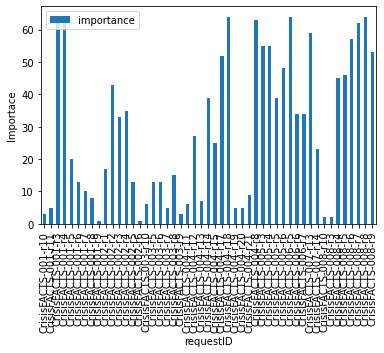

In [ ]:
plot_bar.plot.bar(ylabel='Importace')

In [8]:
def summaryGenerator(dataframe, topn):
  for reqId, group in dataframe.groupby("requestID"):
    # print(reqId, group.shape[0])
    
    summary = " | ".join(group.sort_values(by="importance", ascending=False)["factText"])
    
    return summary

In [9]:
summary = summaryGenerator(submission_df,100)

In [10]:
summary

"when you go to take a sip of water and you end up drinking the whole bottle | I'd love to hear what others have thought of to help save their home, and to expidite an emergency evacuation. | my cup is filled with this tall glass of water🏝 en Solana Beach, California https://t.co/DzXhVz3BkL | With strong winds dying down, evacuations lifted, and the #LilacFire being 95% contained, we are having many of our… https://t.co/L2xSRytHt1 | Thomas Fire claims life of California firefighter https://t.co/rvzpYWVHla #MANDATORY #EVACUATION (NBC Los Angeles)… https://t.co/bGFXRIecJy | We sent around 40 food baskets to Christian Community Services Agency. Glad to help our neighbors in need. #advent… https://t.co/1pDomH5S0Y | @susanmurphysd @KPBSMidday ever 'lived' in shelter? Homeless? I have been'house'less in RV:2k's,&amp; it's about… https://t.co/JbszcPLmUe"

## Self Practise Code

In [ ]:
file_dict = {}
w2v_ranked_df = pd.DataFrame()

# for file in range(0,len(compressed_df.index)):
for file in range(0,1):
  for i in range(0,compressed_df['Event'][file]):
    #Printing event no and fact date
    print("Event: "+stream_df['Event'][i])
    print("Facts_date: "+stream_df['Facts_Date'][i])
    print("Requist ID: "+stream_df["Requist_ID"][i])
    add_to_file = stream_df['Facts_Date'][i]
    req_id = stream_df["Requist_ID"][i]
    #Loading the desired dataset from ir_datasets
    # dataset = ir_datasets.load(stream_df['Facts_Date'][i])

    # Ask pyTerrier to download the dataset, the 'irds:' header tells pyTerrier to use ir_datasets as the data source
    pyTerrierDataset = pt.get_dataset('irds:'+stream_df['Facts_Date'][i])

    # To create the index, we use an 'indexer', this interates over the documents in the collection and adds them to the index
    indexer = pt.index.IterDictIndexer("None", type=pt.index.IndexingType(3), meta=['docno', 'text'], meta_lengths=[40, 200])

    # we give the dataset get_corpus_iter() directly to the indexer
    # while specifying the fields to index and the metadata to record
    index_ref = indexer.index(pyTerrierDataset.get_corpus_iter(), meta=('docno', 'text',))

    #Creating an index
    index = pt.IndexFactory.of(index_ref)
    
    #getting queries for each day of the CrisisFACTs dataset
    # dataset = ir_datasets.load(stream_df['Facts_Date'][i])
    # topics = pd.DataFrame(dataset.queries_iter())
    topics = pyTerrierDataset.get_topics(variant='indicative_terms')
    # corpus = pyTerrierDataset.get_corpus_iter()
    
    # for item in dataset.docs_iter()[:2]: # create an iterator over the stream containing the first 10 items
    #   print(item)

    #Baseline Model using TF_IDF
    retriever = pt.BatchRetrieve(index, wmodel="TF_IDF", metadata=["docno", "text"])
    # retriever = pt.BatchRetrieve(index, wmodel="DFReeKLIM", metadata=["docno", "text"])

    print("Ranking after Baseline model: ")
    baseline_ranked_df = pd.DataFrame(retriever.transform(topics))
    # print(baseline_ranked_df)

    ##Query Expansion
    BM25 = pt.BatchRetrieve(index, controls = {"wmodel": "BM25"},  metadata=["docno", "text"])
    bo1 = BM25 >> pt.rewrite.Bo1QueryExpansion(index) >> BM25
    # klq = pt.rewrite.KLQueryExpansion(index)

    retriever = pt.BatchRetrieve(index, wmodel="DFReeKLIM", metadata=["docno", "text"])
    pipelineQE = (retriever % 100) >> bo1 >> (retriever % 100)

    print("Ranking after Query Expansion using Bo1 model: ")
    QE_ranked_df = pd.DataFrame(pipelineQE.transform(topics))
    # print(QE_ranked_df)

    #Multi-stage retrival
    #this ranker will make the candidate set of documents for each query
    BM25 = pt.BatchRetrieve(index, controls = {"wmodel": "BM25"},  metadata=["docno", "text"])

    #these rankers we will use to re-rank the TF_IDF and PL2 results
    TF_IDF =  pt.BatchRetrieve(index, controls = {"wmodel": "TF_IDF"},  metadata=["docno", "text"])
    PL2 =  pt.BatchRetrieve(index, controls = {"wmodel": "PL2"},  metadata=["docno", "text"])

    #Applying pipeline on BM25 candidate set on top of TF_IDF and PL2
    pipe = BM25 >> (TF_IDF ** PL2)
    fbr = pt.FeaturesBatchRetrieve(index, controls = {"wmodel": "BM25"}, features=["SAMPLE", "WMODEL:TF_IDF", "WMODEL:PL2"], metadata=["docno", "text"]) 

    pipe = BM25 >> (pt.transformer.IdentityTransformer() ** TF_IDF ** PL2)

    #Making retrival process fast using compile() from pyterrier
    pipe_fast = pipe.compile()
    print("Ranking after Multistage retrival model: ")
    custom_ranked_df = (pipe_fast %100).transform(topics)
    # print(custom_ranked_df)

    #Applying word2vec model on top of previously defined pipeline
    test_pipeline = pipe_fast >> pt.apply.by_query(word2vec_func) >> pipe_fast

    #Re-ranking the document using word2vec
    # data = test_pipeline.transform(topics)
    temp_df = pd.DataFrame(test_pipeline.transform(topics))
    w2v_ranked_df = w2v_ranked_df.append(temp_df)
    # w2v_ranked_df = pd.concat(temp_df)
    # pd.DataFrame(w2v_ranked_df.groupby('qid').head(2)).to_csv("Crisis_"+str(req_id)+".csv")
    # w2v_ranked_df["Original Query"] = topics["query"][i]
    w2v_ranked_df["Facts_Date"] = add_to_file
    w2v_ranked_df["RequistID"] = req_id
    #Selecting 2 top events across four streams using all queries.
    print("After word2vec retrival model: ")
    break
  # w2v_ranked_df = pd.concat(w2v_ranked_df)  
  # key = file
  # df = file
  # file_dict[key] = df
  # pd.DataFrame(w2v_ranked_df.groupby('qid').head(2)).to_csv("Crisis_"+str(compressed_df.index[file])+".csv")
  stream_df = stream_df.iloc[compressed_df['Event'][file]:]
  stream_df = stream_df.reset_index(drop=True)  
  print("----------")
  break
  # Trigger the indexing process
  # index = indexer.index(pyTerrierDataset.get_corpus_iter())

Event: Event 001
Facts_date: crisisfacts/001/2017-12-07
Requist ID: CrisisFACTS-001-r3


crisisfacts/001/2017-12-07 documents: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: specifying meta and meta_lengths in IterDictIndexer.index() is deprecated, use constructor instead


Ranking after Baseline model: 
13:13:57.760 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/usr/local/lib/python3.7/dist-packages/pyterrier/datasets.py:435: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop(df.columns.difference(['qid','query']), 1, inplace=True)


Ranking after Query Expansion using Bo1 model: 
13:13:58.297 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:13:58.820 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:13:59.149 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Applying 8 rules
Ranking after Multistage retrival model: 
13:14:03.629 [main] WARN org.terrier.querying.A

In [ ]:
w2v_ranked_df['max'] = w2v_ranked_df.groupby('score')['score'].transform('max')

w2v_ranked_df = w2v_ranked_df.sort_values(["max","score"], ascending=False).drop('max', axis=1)

w2v_ranked_df = w2v_ranked_df.loc[w2v_ranked_df["score"] > 15].groupby("qid").head(1)

In [ ]:
w2v_ranked_df.head()

,qid,docid,docno,text,rank,score,query,features,Facts_Date,RequistID
0,CrisisFACTS-General-q001,6033,CrisisFACTS-001-Reddit-s49-c3-2,Traffic was a nightmare today due to closed ro...,0,13.385644,airport closed bangkok beijing shanghai headin...,"[13.385644255683488, 6.928375606115759, 6.2859...",crisisfacts/001/2017-12-08,CrisisFACTS-001-r4
1,CrisisFACTS-General-q001,16767,CrisisFACTS-001-Twitter-44938-0,@APWestRegion Those who comment that they shou...,1,9.177354,airport closed bangkok beijing shanghai headin...,"[9.177354128488464, 4.9529690475478265, 4.4522...",crisisfacts/001/2017-12-08,CrisisFACTS-001-r4
2,CrisisFACTS-General-q001,16796,CrisisFACTS-001-Twitter-23620-0,Those who comment that they should have been m...,2,9.177354,airport closed bangkok beijing shanghai headin...,"[9.177354128488464, 4.9529690475478265, 4.4522...",crisisfacts/001/2017-12-08,CrisisFACTS-001-r4
3,CrisisFACTS-General-q001,12657,CrisisFACTS-001-Reddit-s55-c273-0,I rode horses for about 5 or 6 years. Never he...,3,8.250825,airport closed bangkok beijing shanghai headin...,"[8.250824619497047, 4.446938630133451, 3.90818...",crisisfacts/001/2017-12-08,CrisisFACTS-001-r4
4,CrisisFACTS-General-q001,10598,CrisisFACTS-001-Twitter-38859-0,@SydneyMTS Same here. I'm close to your locati...,4,8.121160,airport closed bangkok beijing shanghai headin...,"[8.121160171628384, 4.3829468054839635, 3.8778...",crisisfacts/001/2017-12-08,CrisisFACTS-001-r4


In [ ]:
type(test_pipeline.transform(topics))

pandas.core.frame.DataFrame

##Checking stats of currect event

In [ ]:
print('Event: crisisfacts/001/2017-12-07')
print(index.getCollectionStatistics().toString())

Event: crisisfacts/001/2017-12-07
Number of documents: 5437
Number of terms: 3816
Number of postings: 16784
Number of fields: 1
Number of tokens: 17531
Field names: [text]
Positions:   false



Now that we have an index, we can issue queries to it like you would do to a web search engine. Since this is our index, we have control over how we want scoring of the items to happen. Each item is scored using what is known as a weighting model. This is a function that produces a score based on the number of query terms the document contains, in combination with statistics of the documents in the dataset. Different weighting models are optimised for different types of documents. For instance, the classical BM25 model was designed for web pages.

In pyTerrier, we create a retriever object that will execute our queries. We pass the index to the retriever along with the weighting model we want to be used. We can also specify any raw fields we stored in the index for an item that we want to be attached to the search result, such as the original text:

# Baseline Model using TF-IDF


In [ ]:
retriever = pt.BatchRetrieve(index, wmodel="TF_IDF", metadata=["docno", "text"])
# retriever = pt.BatchRetrieve(index, wmodel="DFReeKLIM", metadata=["docno", "text"])

ranked_df = pd.DataFrame(retriever.transform(topics))
ranked_df

NameError: ignored

In [ ]:
# ranked_df.to_json('tf_idf-ranked.json', orient='records', lines=True)

# Query Expansion

In [ ]:
##Query Expansion
BM25 = pt.BatchRetrieve(index, controls = {"wmodel": "BM25"},  metadata=["docno", "text"])
bo1 = BM25 >> pt.rewrite.Bo1QueryExpansion(index) >> BM25
# klq = pt.rewrite.KLQueryExpansion(index)

retriever = pt.BatchRetrieve(index, wmodel="DFReeKLIM", metadata=["docno", "text"])
pipelineQE = (retriever % 100) >> bo1 >> (retriever % 100)

In [ ]:
pd.DataFrame(pipelineQE.transform(topics))

11:49:25.867 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
11:49:26.474 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
11:49:26.898 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


,qid,docid,docno,text,rank,score,query
0,CrisisFACTS-General-q001,3510,CrisisFACTS-001-Twitter-512-0,#lilacFire photos from Palomar airport rd Carl...,0,8.422256,applypipeline:off airport^1.845727872 close^1....
1,CrisisFACTS-General-q001,4001,CrisisFACTS-001-Twitter-5831-0,#LilacFire Smokey here in Oceanside above the ...,1,8.407218,applypipeline:off airport^1.845727872 close^1....
2,CrisisFACTS-General-q001,364,CrisisFACTS-001-Twitter-49822-0,I'm at San Diego International Airport in San ...,2,8.320512,applypipeline:off airport^1.845727872 close^1....
3,CrisisFACTS-General-q001,3712,CrisisFACTS-001-Twitter-23239-0,@justin_ternes Northeast of El Camino Real and...,3,8.312118,applypipeline:off airport^1.845727872 close^1....
4,CrisisFACTS-General-q001,532,CrisisFACTS-001-Twitter-22676-0,Back to Cali . . . #california #sandiego # # @...,4,8.265814,applypipeline:off airport^1.845727872 close^1....
...,...,...,...,...,...,...,...
48981,CrisisFACTS-Wildfire-q006,133,CrisisFACTS-001-News-8-23,"The blaze, reported about 1:15 p.m. near Los A...",95,2.973472,applypipeline:off fire^1.081699906 contain^1.0...
48982,CrisisFACTS-Wildfire-q006,2812,CrisisFACTS-001-News-38-2,"By 8 p.m., the Lilac fire had grown to 4,100 a...",96,2.973472,applypipeline:off fire^1.081699906 contain^1.0...
48983,CrisisFACTS-Wildfire-q006,3552,CrisisFACTS-001-Twitter-22533-0,#LilacFire The fire is now 100-150 acres &amp;...,97,2.958183,applypipeline:off fire^1.081699906 contain^1.0...
48984,CrisisFACTS-Wildfire-q006,3636,CrisisFACTS-001-Twitter-31377-0,#LilacFire The fire is now 100-150 acres &amp...,98,2.958183,applypipeline:off fire^1.081699906 contain^1.0...


# Multi-stage Retrieval

In [ ]:
#this ranker will make the candidate set of documents for each query
BM25 = pt.BatchRetrieve(index, controls = {"wmodel": "BM25"},  metadata=["docno", "text"])

#these rankers we will use to re-rank the TF_IDF and PL2 results
TF_IDF =  pt.BatchRetrieve(index, controls = {"wmodel": "TF_IDF"},  metadata=["docno", "text"])
PL2 =  pt.BatchRetrieve(index, controls = {"wmodel": "PL2"},  metadata=["docno", "text"])

In [ ]:
pipe = BM25 >> (TF_IDF ** PL2)
pipe.transform(topics)

13:38:55.560 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:38:56.595 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:38:57.559 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


,qid,docid,docno,text,rank,score,query,features
0,CrisisFACTS-General-q001,1513,CrisisFACTS-001-Twitter-48717-0,Good to be home again! @ San Diego Internation...,0,10.840907,airport closed,"[5.959746115803786, 5.434001669923279]"
1,CrisisFACTS-General-q001,4001,CrisisFACTS-001-Twitter-5831-0,#LilacFire Smokey here in Oceanside above the ...,1,10.365301,airport closed,"[5.698283354422201, 5.181268577133161]"
2,CrisisFACTS-General-q001,3510,CrisisFACTS-001-Twitter-512-0,#lilacFire photos from Palomar airport rd Carl...,2,9.929671,airport closed,"[5.458797921543436, 4.952882979095842]"
3,CrisisFACTS-General-q001,532,CrisisFACTS-001-Twitter-22676-0,Back to Cali . . . #california #sandiego # # @...,3,9.529182,airport closed,"[5.2386306112173004, 4.744836590959179]"
4,CrisisFACTS-General-q001,364,CrisisFACTS-001-Twitter-49822-0,I'm at San Diego International Airport in San ...,4,9.159746,airport closed,"[5.035534595592607, 4.554075159436155]"
...,...,...,...,...,...,...,...,...
8996,CrisisFACTS-Wildfire-q006,338,CrisisFACTS-001-News-19-11,Creek fire in northeast San Fernando Valley 1...,184,3.288778,containment,"[1.8208355675518322, 1.497431333559856]"
8997,CrisisFACTS-Wildfire-q006,339,CrisisFACTS-001-News-19-12,https://t.co/ZMx1UKojdE pic.twitter.com/Tptsg8...,185,3.208158,containment,"[1.7762005299317922, 1.451470494726682]"
8998,CrisisFACTS-Wildfire-q006,336,CrisisFACTS-001-News-19-9,Thomas fire in Ventura and Santa Barbara count...,186,3.131397,containment,"[1.733701453690955, 1.4075047602952049]"
8999,CrisisFACTS-Wildfire-q006,340,CrisisFACTS-001-News-19-13,"Lilac fire in San Diego County 4,100 acres bu...",187,3.058223,containment,"[1.693188600436249, 1.3653893495946197]"


In [ ]:
fbr = pt.FeaturesBatchRetrieve(index, controls = {"wmodel": "BM25"}, features=["SAMPLE", "WMODEL:TF_IDF", "WMODEL:PL2"], metadata=["docno", "text"]) 

pipe = BM25 >> (pt.transformer.IdentityTransformer() ** TF_IDF ** PL2)
#look at the top 100 results
(fbr %100).transform(topics)

13:39:04.236 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


,qid,query,docid,rank,features,docno,text,score
0,CrisisFACTS-General-q001,airport closed,1513,0,"[10.840907078668243, 1.8888947026336904, 1.535...",CrisisFACTS-001-Twitter-48717-0,Good to be home again! @ San Diego Internation...,10.840907
1,CrisisFACTS-General-q001,airport closed,4001,1,"[10.365300660946287, 2.034966369838934, 1.6832...",CrisisFACTS-001-Twitter-5831-0,#LilacFire Smokey here in Oceanside above the ...,10.365301
2,CrisisFACTS-General-q001,airport closed,3510,2,"[9.929671479084204, 1.983828675112109, 1.63176...",CrisisFACTS-001-Twitter-512-0,#lilacFire photos from Palomar airport rd Carl...,9.929671
3,CrisisFACTS-General-q001,airport closed,532,3,"[9.529182379946793, 2.0888102021206136, 1.7371...",CrisisFACTS-001-Twitter-22676-0,Back to Cali . . . #california #sandiego # # @...,9.529182
4,CrisisFACTS-General-q001,airport closed,364,4,"[9.159746335079618, 2.034966369838934, 1.68321...",CrisisFACTS-001-Twitter-49822-0,I'm at San Diego International Airport in San ...,9.159746
...,...,...,...,...,...,...,...,...
8907,CrisisFACTS-Wildfire-q006,containment,3390,95,"[4.392621516780349, 3.3247012032612195, 3.0397...",CrisisFACTS-001-Twitter-44500-0,RT @nbcsandiego: #BREAKING: The #LilacFire has...,4.392622
8908,CrisisFACTS-Wildfire-q006,containment,3454,96,"[4.392621516780349, 2.4319800925912967, 2.1147...",CrisisFACTS-001-Twitter-35144-0,#BREAKING: The #LilacFire burning in the Bonsa...,4.392622
8909,CrisisFACTS-Wildfire-q006,containment,3581,97,"[4.392621516780349, 3.484589789337811, 3.21781...",CrisisFACTS-001-Twitter-15242-0,#LilacFire as seen from #CSUSM. It's burning n...,4.392622
8910,CrisisFACTS-Wildfire-q006,containment,3992,98,"[4.392621516780349, 2.3530039613044473, 2.0354...",CrisisFACTS-001-Twitter-18545-0,#LilacFire updates: --Between 100-150 acres bu...,4.392622


In [ ]:
pipe_fast = pipe.compile()
custom_rankedd_df = (pipe_fast %100).transform(topics)

Applying 8 rules


In [ ]:
pipe_fast.transform('evacuated')

/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:887: FutureWarning: .transform() should be passed a dataframe. Use .search() to execute a single query.
  topics = m.transform(topics)


,qid,docid,docno,text,rank,score,query,features
0,1,7082,CrisisFACTS-001-Twitter-26352-0,Temporary evacuation information #LilacFire #F...,0,5.252715,evacuated,"[5.252714720050483, 3.0617048531517845, 3.0979..."
1,1,6504,CrisisFACTS-001-Twitter-44011-0,Updated evacuation map for #LilacFire. Yellow ...,1,4.973554,evacuated,"[4.973553979278057, 2.8989875078579646, 2.8829..."
2,1,5900,CrisisFACTS-001-Twitter-15149-0,If ordered to evacuate please evacuate. #prayf...,2,4.954042,evacuated,"[4.954042338964, 2.8876145536759172, 2.8429577..."
3,1,5628,CrisisFACTS-001-Twitter-15975-0,"Please, please, please think of the animals as...",3,4.817091,evacuated,"[4.817091054547189, 2.8077883239087145, 2.7333..."
4,1,5664,CrisisFACTS-001-Twitter-13722-0,Please tag your horses if you are planning to ...,4,4.817091,evacuated,"[4.817091054547189, 2.8077883239087145, 2.7333..."
...,...,...,...,...,...,...,...,...
594,1,2261,CrisisFACTS-001-News-32-5,EVACUATION SHELTERS EL CAJON: Bostonia Park &...,594,2.189437,evacuated,"[2.1894366011694317, 1.2761798469428722, 0.986..."
595,1,108,CrisisFACTS-001-News-7-14,Evacuation centers accepting pets: Palomar Col...,595,2.135766,evacuated,"[2.1357658651615203, 1.2448962228236335, 0.954..."
596,1,2266,CrisisFACTS-001-News-32-10,People who need assistance evacuating large an...,596,2.135766,evacuated,"[2.1357658651615203, 1.2448962228236335, 0.954..."
597,1,2930,CrisisFACTS-001-News-39-7,SAN DIEGO AIR QUALITY LEVELS Evacuation order...,597,2.084663,evacuated,"[2.0846634840922142, 1.2151096426519998, 0.922..."


#Building ground truths JSON file into dataframe for training purpose

In [2]:
from google.colab import drive
drive.mount('/content/drive')
root_path = 'drive/My Drive/Project_2022/'

# import pandas as pd
# facts_df = pd.read_json('CrisisFACTs-2022.json', orient='records')

# facts_df.head(5)

Mounted at /content/drive


In [3]:
import json 
import pandas as pd 
from pandas.io.json import json_normalize

# facts_df = pd.read_json('CrisisFACTs-2022.json')
# facts_df.head(1)

with open(root_path +'CrisisFACTs-2022.json') as f:
    d = json.load(f)

In [4]:

rows = []

for item in d:
    event = item['event']
    eventID   = item['eventID'] 

    for req in item['summaryRequests']:
        requestID = req['requestID']

        for req_desc in item['factsByRequest'][requestID]: 
            fact = req_desc['fact']
            rows.append( [event, eventID, requestID, fact] )

            # print(f'{event} | {eventID} | {requestID} | {fact}')

golden_df = pd.DataFrame(rows, columns=['event', 'eventID', 'requestID', 'fact']) 

In [ ]:
golden_df

,event,eventID,requestID,fact
0,Lilac Wildfire 2017,CrisisFACTS-001,CrisisFACTS-001-r3,Prediction for San Diego was VERY high wind Th...
1,Lilac Wildfire 2017,CrisisFACTS-001,CrisisFACTS-001-r3,Horse trailers needed at Quail Haven Farms in ...
2,Lilac Wildfire 2017,CrisisFACTS-001,CrisisFACTS-001-r3,Wind casting embers
3,Lilac Wildfire 2017,CrisisFACTS-001,CrisisFACTS-001-r3,Winds getting stronger in my area of San Diego.
4,Lilac Wildfire 2017,CrisisFACTS-001,CrisisFACTS-001-r3,I heard that at 11am
...,...,...,...,...
1477,Hurricane Sally 2020,CrisisFACTS-008,CrisisFACTS-008-r9,continued to weaken quickly as it moved farthe...
1478,Hurricane Sally 2020,CrisisFACTS-008,CrisisFACTS-008-r9,merged with a frontal boundary and became extr...
1479,Hurricane Sally 2020,CrisisFACTS-008,CrisisFACTS-008-r9,In Lafourche Parish
1480,Hurricane Sally 2020,CrisisFACTS-008,CrisisFACTS-008-r9,No fatalities or injuries were reported in Lou...


In [5]:
golden_summary = " ".join(golden_df["fact"])

In [6]:
len(golden_summary)

126594

In [ ]:
def split_in_files(json_data, amount):
    step = len(json_data) // amount
    pos = 0
    for i in range(amount - 1):
        with open('output_file{}.json'.format(i+1), 'w') as file:
            json.dump(json_data[pos:pos+step], file)
            pos += step
    # last one
    with open('output_file{}.json'.format(amount), 'w') as file:
        json.dump(json_data[pos:], file)

# split_in_files(json_data, len(event_name_df))

#Custome model

In [ ]:
import gensim

In [ ]:
clean_text = custom_rankedd_df.text.apply(gensim.utils.simple_preprocess)

In [ ]:
clean_text

0       [good, to, be, home, again, san, diego, intern...
1       [lilacfire, smokey, here, in, oceanside, above...
2       [lilacfire, photos, from, palomar, airport, rd...
3       [back, to, cali, california, sandiego, san, di...
4       [at, san, diego, international, airport, in, s...
                              ...                        
8907    [rt, nbcsandiego, breaking, the, lilacfire, ha...
8908    [breaking, the, lilacfire, burning, in, the, b...
8909    [lilacfire, as, seen, from, csusm, it, burning...
8910    [lilacfire, updates, between, acres, burned, c...
8911    [breaking, news, the, lilacfire, has, exploded...
Name: text, Length: 3364, dtype: object

In [ ]:
from pandas.core import window
custome_model = gensim.models.Word2Vec(
    window = 3,
    min_count = 2,
    workers = 4
)

In [ ]:
#Building vocab
custome_model.build_vocab(clean_text, progress_per=1000)

In [ ]:
custome_model.epochs

5

In [ ]:
#Train the model
custome_model.train(clean_text, total_examples=custome_model.corpus_count, epochs=custome_model.epochs)

(208654, 292110)

In [ ]:
#saving model
custome_model.save('./custom_model.model')

In [ ]:
custome_model.similarity(w1="evacuated", w2="water")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.99966383

#Pre-trained model

In [ ]:
# %time model = api.load("glove-wiki-gigaword-300")
%time model = api.load("glove-twitter-25")
# %time model = api.load('glove-twitter-200')

[==================================================] 100.0% 104.8/104.8MB downloaded
CPU times: user 54 s, sys: 4.87 s, total: 58.9 s
Wall time: 1min 1s


In [ ]:
emb = model.get_vector("airport")
print(emb.shape)
print(emb)

(25,)
[-2.0865e+00 -2.1981e-03  8.4930e-01 -1.4564e+00 -8.3844e-01 -8.0157e-01
  4.4099e-01  3.7413e-01  1.4009e+00  4.0926e-01 -1.0263e-01  7.7931e-01
 -2.8374e+00  5.7789e-01  7.0094e-01 -9.8445e-01  2.0104e-01  3.6623e-01
 -1.0395e+00 -2.7583e-01 -1.6308e-01 -1.4543e+00  4.2966e-01 -1.1305e+00
 -2.5316e-01]


In [ ]:
model.most_similar("evacuated")

[('diverted', 0.8607070446014404),
 ('raided', 0.8510200381278992),
 ('offices', 0.8429232239723206),
 ('firefighters', 0.8372986316680908),
 ('transported', 0.8277961015701294),
 ('factories', 0.8258089423179626),
 ('courthouse', 0.8183614015579224),
 ('halted', 0.814586341381073),
 ('demolished', 0.8140581250190735),
 ('disrupted', 0.8140448331832886)]

In [ ]:
model.similarity(w1="evacuated", w2="water")

0.37149754

# Re-ranking using Machine learning  i.e Lerning to Rank

In [ ]:
bm25_cands = pt.BatchRetrieve(index, wmodel="BM25")
dph_cands = pt.BatchRetrieve(index, wmodel="DPH")
all_cands = bm25_cands | dph_cands

all_features = all_cands >> (  
    pt.BatchRetrieve(index, wmodel="BM25F") **
    pt.rewrite.SDM() >> pt.BatchRetrieve(index, wmodel="BM25")
    )

import xgboost as xgb
params = {'objective': 'rank:ndcg', 
          'learning_rate': 0.1, 
          'gamma': 1.0, 'min_child_weight': 0.1,
          'max_depth': 6,
          'verbose': 2,
          'random_state': 42 
         }
lambdamart = pt.ltr.apply_learned_model(xgb.sklearn.XGBRanker(**params), form='ltr')
final_pipe = all_features >> lambdamart

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
dataset1 = pt.datasets.get_dataset("vaswani")
indexref1 = dataset1.get_index()
topics1 = dataset1.get_topics()
qrels1 = dataset1.get_qrels()

data.direct.bf:   0%|          | 0.00/388k [00:00<?, ?iB/s]

data.document.fsarrayfile:   0%|          | 0.00/234k [00:00<?, ?iB/s]

data.inverted.bf:   0%|          | 0.00/362k [00:00<?, ?iB/s]

data.lexicon.fsomapfile:   0%|          | 0.00/682k [00:00<?, ?iB/s]

data.lexicon.fsomaphash:   0%|          | 0.00/777 [00:00<?, ?iB/s]

data.lexicon.fsomapid:   0%|          | 0.00/30.3k [00:00<?, ?iB/s]

data.meta-0.fsomapfile:   0%|          | 0.00/725k [00:00<?, ?iB/s]

data.meta.idx:   0%|          | 0.00/89.3k [00:00<?, ?iB/s]

data.meta.zdata:   0%|          | 0.00/224k [00:00<?, ?iB/s]

data.properties:   0%|          | 0.00/4.29k [00:00<?, ?iB/s]

md5sums:   0%|          | 0.00/619 [00:00<?, ?iB/s]

query-text.trec:   0%|          | 0.00/3.05k [00:00<?, ?iB/s]

qrels:   0%|          | 0.00/6.63k [00:00<?, ?iB/s]

In [ ]:
fbr = pt.FeaturesBatchRetrieve(indexref1, controls = {"wmodel": "BM25"}, features=["WMODEL:TF_IDF", "WMODEL:PL2"]) 
# the top 2 results
(fbr %2).search("chemical")

,qid,query,docid,rank,features,docno,score
0,1,chemical,10702,0,"[1.9972714735280614, 1.590216305943686]",10703,13.472012
1,1,chemical,1055,1,"[2.5168371014881425, 2.1297038460724336]",1056,12.517082


In [ ]:
from ir_datasets.util import metadata
# BaselineLTR = fbr >> pt.pipelines.LTR_pipeline(RandomForestRegressor(n_estimators=400))
import numpy as np
train_topics, valid_topics, test_topics = np.split(topics1, [int(.6*len(topics1)), int(.8*len(topics1))])

import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

lmart_l = lgb.LGBMRanker(task="train",
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=100,
    max_bin=255,
    num_leaves=7,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[1, 3, 5, 10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=10,
    metadata=["docno", "text"])

lmart_l_pipe = fbr >> pt.ltr.apply_learned_model(lmart_l, form="ltr")
lmart_l_pipe.fit(train_topics, qrels1, valid_topics, qrels1)



/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's ndcg@1: 0.526316
[2]	valid_0's ndcg@1: 0.368421
[3]	valid_0's ndcg@1: 0.368421
[4]	valid_0's ndcg@1: 0.315789
[5]	valid_0's ndcg@1: 0.263158
[6]	valid_0's ndcg@1: 0.263158
[7]	valid_0's ndcg@1: 0.263158
[8]	valid_0's ndcg@1: 0.263158
[9]	valid_0's ndcg@1: 0.263158
[10]	valid_0's ndcg@1: 0.210526


In [ ]:
pd.DataFrame(lmart_l_pipe.search('chemical'))

,qid,query,docid,features,docno,score,rank
0,1,chemical,10702,"[1.9972714735280614, 1.590216305943686]",10703,0.191864,0
2,1,chemical,4885,"[2.3728103620913967, 1.983371320830459]",4886,0.052304,1
1,1,chemical,1055,"[2.5168371014881425, 2.1297038460724336]",1056,0.032782,2
6,1,chemical,10138,"[3.4834162139007545, 3.0708350019597836]",10139,-0.118626,3
3,1,chemical,6278,"[4.127360117137546, 3.67541591591923]",6279,-0.180456,4
4,1,chemical,1139,"[4.733102135127965, 4.239937921699505]",1140,-0.296689,5
14,1,chemical,4911,"[4.892671258538515, 4.389142244890826]",4912,-0.314971,6
5,1,chemical,8765,"[5.063375014663324, 4.549375729649994]",8766,-0.327094,7
7,1,chemical,2519,"[5.063375014663324, 4.549375729649994]",2520,-0.327094,8
8,1,chemical,2557,"[4.97655971570293, 4.4677913542010534]",2558,-0.327094,9


In [ ]:
from collections import Counter
def slash_counter(url):
  counter = Counter(url)
  return counter['/']

In [ ]:
improved_pl2_pipeline = pipe_fast >>pt.apply.doc_score(lambda row:slash_counter(row['text']),verbose=True)


In [ ]:
improved_pl2_pipeline.transform('evacuated').head()

/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:887: FutureWarning: .transform() should be passed a dataframe. Use .search() to execute a single query.
  topics = m.transform(topics)


pt.apply.doc_score:   0%|          | 0/599 [00:00<?, ?d/s]

,qid,docid,docno,text,score,query,features,rank
0,1,7082,CrisisFACTS-001-Twitter-26352-0,Temporary evacuation information #LilacFire #F...,3,evacuated,"[5.252714720050483, 3.0617048531517845, 3.0979...",44
1,1,6504,CrisisFACTS-001-Twitter-44011-0,Updated evacuation map for #LilacFire. Yellow ...,3,evacuated,"[4.973553979278057, 2.8989875078579646, 2.8829...",45
2,1,5900,CrisisFACTS-001-Twitter-15149-0,If ordered to evacuate please evacuate. #prayf...,3,evacuated,"[4.954042338964, 2.8876145536759172, 2.8429577...",46
3,1,5628,CrisisFACTS-001-Twitter-15975-0,"Please, please, please think of the animals as...",3,evacuated,"[4.817091054547189, 2.8077883239087145, 2.7333...",47
4,1,5664,CrisisFACTS-001-Twitter-13722-0,Please tag your horses if you are planning to ...,3,evacuated,"[4.817091054547189, 2.8077883239087145, 2.7333...",48


#Evaluation

##Rouge

In [15]:
pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
from rouge import Rouge

rouge = Rouge()

rouge.get_scores(summary, golden_summary, avg=True)

{'rouge-1': {'f': 0.022866153744030244,
  'p': 0.5523809523809524,
  'r': 0.011674718196457327},
 'rouge-2': {'f': 0.0016709599250780758,
  'p': 0.0916030534351145,
  'r': 0.0008431703204047217},
 'rouge-l': {'f': 0.020500689521676604,
  'p': 0.49523809523809526,
  'r': 0.010466988727858293}}

In [ ]:
from rouge import Rouge

hypo = ["he began by starting a five person war cabinet and included chamberlain as lord president of the council",
             "the siege lasted from 250 to 241 bc, the romans laid siege to lilybaeum",
             "the original ocean water was found in aquaculture"]

reference = ["hello",
             "he began his premiership by forming a five-man war cabinet which included chamberlain as lord president of the council",
             "the original mission was for research into the uses of deep ocean water in ocean thermal energy conversion (otec) renewable energy production and in aquaculture"]

rouge = Rouge()

rouge.get_scores(hypo, reference, avg=True)



{'rouge-1': {'f': 0.18314175957221135,
  'p': 0.32196969696969696,
  'r': 0.1286549707602339},
 'rouge-2': {'f': 0.06451612786680543,
  'p': 0.14285714285714285,
  'r': 0.041666666666666664},
 'rouge-l': {'f': 0.1601532538250849,
  'p': 0.28030303030303033,
  'r': 0.11278195488721804}}

#Hypothesis and Reference

In [ ]:
reference1 = ['It', 'is', 'a', 'guide', 'to', 'action', 'that', 'ensures', 'that', 'the', 'military', 'will', 'forever', 'heed', 'Party', 'commands']
reference2 = ['It', 'is', 'the', 'guiding', 'principle', 'which', 'guarantees', 'the', 'military', 'forces', 'always', 'being', 'under', 'the', 'command', 'of', 'the', 'Party']
reference3 = ['It', 'is', 'the', 'practical', 'guide', 'for', 'the', 'army', 'always', 'to', 'heed', 'the', 'directions', 'of', 'the', 'party']

hypothesis1 = ['It', 'is', 'a', 'guide', 'to', 'action', 'which', 'ensures', 'that', 'the', 'military', 'always', 'obeys', 'the', 'commands', 'of', 'the', 'party']
hypothesis2 = ['It', 'is', 'to', 'insure', 'the', 'troops', 'forever', 'hearing', 'the', 'activity', 'guidebook', 'that', 'party', 'direct']

#BLEU

In [13]:
from nltk.translate.bleu_score import sentence_bleu
import nltk

In [28]:
sentence_bleu([summary], golden_summary)

0.005659780623695281

#METEOR

In [ ]:
from nltk.translate import meteor_score
import nltk


In [49]:
nltk.translate.meteor_score.meteor_score([summary], [[golden_summary]], gamma = 0)

TypeError: ignored

#BERT-SCORE

In [41]:
from bert_score import score

In [44]:
P, R, F1 = score([summary], [golden_summary], lang='en', verbose=True)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 10.45 seconds, 0.10 sentences/sec


In [47]:
print(f"System level P score: {P.mean():.3f}")
print(f"System level R score: {R.mean():.3f}")
print(f"System level F1 score: {F1.mean():.3f}")

System level P score: 0.763
System level R score: 0.781
System level F1 score: 0.772
